## Evaluation Calibration and timeconstant measurements Tsensors

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as colors
import io
import glob
from pandas.tseries.offsets import DateOffset

### Bring all files to the same time axis

In [51]:
#load the data files:
filenames = glob.glob("Tsensor_measurements/*.LOG")
path_timeaxis = 'Tsensor_measurements/files_timeaxis/'


#load in the temperature measurement of the Greisinger thermometer for the time constant    
timeconst = pd.read_csv('Tsensor_measurements/tsensor_calibration_time_constant.log', comment='#',
                          names=["time","temperature"])
timeconst['time']= pd.to_datetime(timeconst["time"], utc=True).dt.tz_localize(None)
start_shock = timeconst['time'].values[2]

#set counter variable and variable for storing the indices of the shock time
k=0
millis_start = np.zeros(8,int)

#find the index of shock time for all temperature sensors
for filename in filenames:
    #load in files file by file
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    tsensor["time"] = pd.to_datetime(tsensor["time"], utc=True).dt.tz_localize(None)
    
    #create timeaxis for files with wrong time axis (DKB and LG)
    if (filename== filenames[2]) or (filename == filenames[6]):
        #set time to time of QR and create artifical time axis using the millis
        tsensor["time"] = tsensor["time"].copy()+DateOffset(years=23,months=2,days=1,hours=15,minutes=48)
        for i in range(0,len(tsensor["time"].values)):
            tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)
    
    #calculate temporal temperature changes between timestamps
    diff = tsensor['temperature'].values[1:] - tsensor['temperature'].values[:-1]
    
    #find index of value that is closest to 200000ms (temperature seems to be relatively const 200000ms onwards)
    diff_200000 = abs(tsensor['millis']-200000)
    millis_200000 = np.where(diff_200000 == min(diff_200000))[0][0]
    
    #find "start time", where temporal temperature change is larger than 0.1°C
    millis_start[k] = np.where(abs(diff[millis_200000:350]) >= 0.1)[0][0] + millis_200000
    start_time = tsensor['millis'][millis_start[k]]
    
    #calculate offset to laboratoy measurement at shock time and redefine time axis:
    offset = tsensor['time'].values[millis_start[k]]-start_shock    
    tsensor['time'] = tsensor['time']- offset
    
    #store files with adjusted time axes
    name = filename.split("/")[-1].split("_")[-1].split(".")[0]
    tsensor.to_csv(path_timeaxis + name + '.LOG', header=None, index=False)

    k+=1

<ipython-input-51-92e8955e6707>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)
<ipython-input-51-92e8955e6707>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsensor["time"][i] = tsensor["time"][i]+DateOffset(seconds=tsensor["millis"].values[i]/1000)


### Calibration

In [52]:
#load the calibration file of the Greisinger thermometer
calibration = pd.read_csv('Tsensor_measurements/tsensor_calibration.log', sep=',', 
                            comment='#',names=["time","millis","ID","temperature"])
calibration["time"] = pd.to_datetime(calibration["time"], utc=True).dt.tz_localize(None)

In [53]:
#load filenames of timeaxis corrected files
files = glob.glob(path_timeaxis+"*.LOG")

#creation of an interpolated dataframe of labatory and sensor measurements:
df1 = calibration.copy()
df1_1 = df1[['time','temperature']].rename(columns={"temperature": "Calibration"})
df1_1['time'] = pd.to_datetime(df1["time"], utc=True).dt.tz_localize(None)
df1 = df1_1.copy()

#loop over the temperature sensor measurements:
for count, file in enumerate(files[:]):
    #read in the temperature sensor measurements
    name = file.split("/")[-1].split("_")[-1].split(".")[0]
    df2 = pd.read_csv(file, sep=',', comment='#',names=["time","millis","sensorID","temperature"])
    
    #create dataframe containing only time and temperature values of the sensor measurements
    df2 = df2[["time","temperature"]].rename(columns={"temperature": name})
    df2["time"] = pd.to_datetime(df2["time"], utc=True).dt.tz_localize(None)
    
    #merge dataframe of calibration measurements with temperature sensor measurements
    df1_1 = pd.merge_ordered(df1_1, df2)

#set index of merged dataframe to the timestamp and reindex with the timestamps of the calibration measurements
df1_1.set_index(['time'], inplace = True)
df1_1 = (df1_1.interpolate(method = "time")).reindex(df1.time)

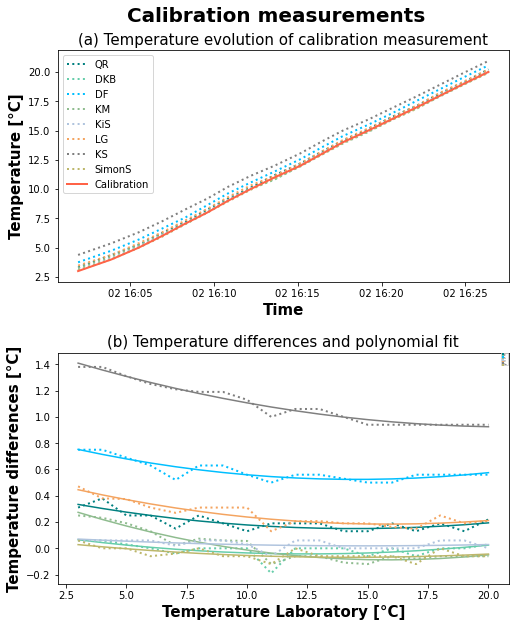

In [54]:
## Calculate 2nd order polynomial fit for three point calibration

#set variables for the names of the different temperature sensors and a color scheme for plots
sensor_list = df1_1.columns.values.tolist()[:]
c = ['tomato', 'teal', 'mediumaquamarine', 'deepskyblue', 'darkseagreen', 'lightsteelblue', 'sandybrown',
     '#7f7f7f', 'darkkhaki', '#17becf']

#start the figure command for 2 subplots
fig, (ax1,ax2) = plt.subplots(2, figsize=(7,8))
fig.tight_layout(h_pad=5)


#set variables for the calulated fit in the y-variable and the fit parameters
fit_y = np.zeros((len(sensor_list[1:]),len(df1_1[sensor_list[0]])))
fit_parameter = {}

#2nd order polnomial fit for calibration (y=ax²+bx+c)
for i, sensor in enumerate(sensor_list[1:]):
    #calculation of the fit parameters a, b, c
    fit_parameter[sensor] = np.polyfit(df1_1[sensor_list[0]].values, df1_1[sensor].values-
                                       df1_1[sensor_list[0]].values, 2)
    
    #calculation of polynomial fit using the fit parameters
    fit_y[i] = (fit_parameter[sensor][2]+fit_parameter[sensor][1]*df1_1[sensor_list[0]]+
                fit_parameter[sensor][0]*df1_1[sensor_list[0]]**2)
    
    #plot the fit and calibration measurement:
    
    #plot of temperature evolution over time of the calibration measurement time series
    ax1.plot(df1_1.index,df1_1[sensor],label=sensor, c= c[i+1], linestyle = "dotted", linewidth=2)
    ax1.set_xlabel('Time',size = 15,weight='semibold')
    ax1.set_ylabel('Temperature [°C]',size=15,weight='semibold')
    ax1.set_title('(a) Temperature evolution of calibration measurement', fontsize = 15)

    #plot of temperature differences between temperture sensors and polynomial fit
    ax2.plot(df1_1[sensor_list[0]],fit_y[i], c= c[i+1])
    ax2.plot(df1_1[sensor_list[0]].values,df1_1[sensor].values-df1_1[sensor_list[0]].values,label = sensor,
             alpha = 1,linestyle = "dotted", linewidth = 2, c=c[i+1])
    ax2.set_xlabel('Temperature Laboratory [°C]',size = 15,weight='semibold')
    ax2.set_ylabel('Temperature differences [°C]',size=15,weight='semibold')
    ax2.legend(prop=dict(size=1))
    ax2.set_title('(b) Temperature differences and polynomial fit', fontsize = 15)

ax1.plot(df1_1.index,df1_1['Calibration'],label='Calibration', c= c[0], linewidth=2)
ax1.legend(prop=dict(size=10))
my_suptitle = fig.suptitle('Calibration measurements', fontsize=20, fontweight='bold', y=1.05)

fig.savefig('Plots/Calibration_measurements.pdf',dpi=fig.dpi, bbox_inches='tight',bbox_extra_artists=[my_suptitle])

#### Calibration of all files

In [55]:
#Create path for storing the calibrated files
path_storage_calib = path_timeaxis + '/calib/'

#set counter
k=0

#calibration correction for all temperature sensor files
for filename in files:
    #load in all files file by file and convert time to datetime
    name = filename.split("/")[-1].split("_")[-1].split(".")[0]
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    tsensor['time'] = pd.to_datetime(tsensor["time"], utc=True).dt.tz_localize(None) 

    #calibration correction of the temperature
    tsensor['temperature'] = tsensor['temperature'] - (fit_parameter[name][2]+tsensor['temperature']*
                                                       fit_parameter[name][1]+fit_parameter[name][0]*
                                                       tsensor['temperature']**2)
    
    #storage of calibration corrected temperature measurements
    tsensor.to_csv(path_storage_calib + name + '.LOG', header=None, index=False)
    
    k+=1

### Time constant

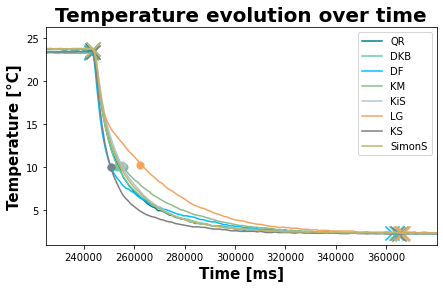

In [56]:
#Load filenames of the correlation corrected temperature measurements
filenames = glob.glob(path_storage_calib+'*.LOG')

#initialise the figure and color scheme for plotting
fig=plt.figure(figsize=(7,4))
c = ['tomato', 'teal', 'mediumaquamarine', 'deepskyblue', 'darkseagreen', 'lightsteelblue', 'sandybrown',
  '#7f7f7f', 'darkkhaki', '#17becf']

#set counter variable and variable for storing the indices of the shock time
i=0
millis_start = np.zeros(8, int)
for filename in filenames:
    #load in all files file by file
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    
    #calculate temporal changes:
    diff = tsensor['temperature'].values[1:] - tsensor['temperature'].values[:-1]
    
    #find index of value that is closest to 200000ms
    diff_200000 = abs(tsensor['millis']-200000)
    millis_200000 = np.where(diff_200000 == min(diff_200000))[0][0]
    
    #find "start time", where temporal temperature change is larger than 0.1°C
    millis_start[i] = np.where(abs(diff[millis_200000:350]) >= 0.1)[0][0] + millis_200000
    start_time = tsensor['millis'][millis_start[i]]
    
    #find "end time", where temporan temperature change over an interval of n = 100s is smaller than 0.1°C
    sum_diff = np.zeros(len(diff))
    n= 100
    for k in range(len(diff)-n):
        sum_diff[k+n-1] = np.nanmean(diff[k:k+n-1])
    millis_end = np.where(abs(sum_diff[millis_start[i]+n:]) <= 0.1)[0][0]
    end_time = tsensor['millis'][millis_start[i]+millis_end+n]  
    
    ##find start and end temperature by averaging over 30s:
    temp_start = np.mean(tsensor['temperature'].values[millis_start[i]-30:\
                                                       millis_start[i]+1])
    temp_end = np.mean(tsensor['temperature'].values[millis_start[i]+millis_end+n:\
                                                     millis_start[i]+millis_end+n+31])
    
    #calculate start and end temperatures and time constant
    Temp_tau = temp_end + 1/np.e *(temp_start - temp_end)
    diff_temp = abs(tsensor['temperature'].values[:330] - Temp_tau)
    time_tau = tsensor['millis'].values[np.where(diff_temp == min(diff_temp))[0][0]]
    
    
    #plot of the sensors:
    plt.scatter(start_time, tsensor['temperature'].values[millis_start[i]],s=200, c = c[i+1], marker='x')
    plt.scatter(end_time, tsensor['temperature'].values[millis_start[i]+millis_end+n],s=200, c=c[i+1],
                marker='x')
    plt.plot(tsensor["millis"], tsensor["temperature"], c=c[i+1], label = filename.split("/")[-1].
             split("_")[-1].split(".")[0])
    #plt.scatter(end_time, tsensor['temperature'].values[millis_start[i]+millis_end+n],s=100, c=c[i+1],
    #            marker='x')
    plt.scatter(time_tau, Temp_tau, c=c[i+1], s=50)
    plt.xlabel('Time [ms]',size = 15,weight='semibold')
    plt.ylabel('Temperature [°C]',size=15,weight='semibold')
    plt.legend(prop=dict(size=13))
    plt.title('Temperature evolution over time', fontsize=20, fontweight='bold')
    plt.legend()
    plt.xlim(225000,379999)
    
    plt.savefig('Plots/Time_constant.pdf')
    
    i += 1

## Plot for the report

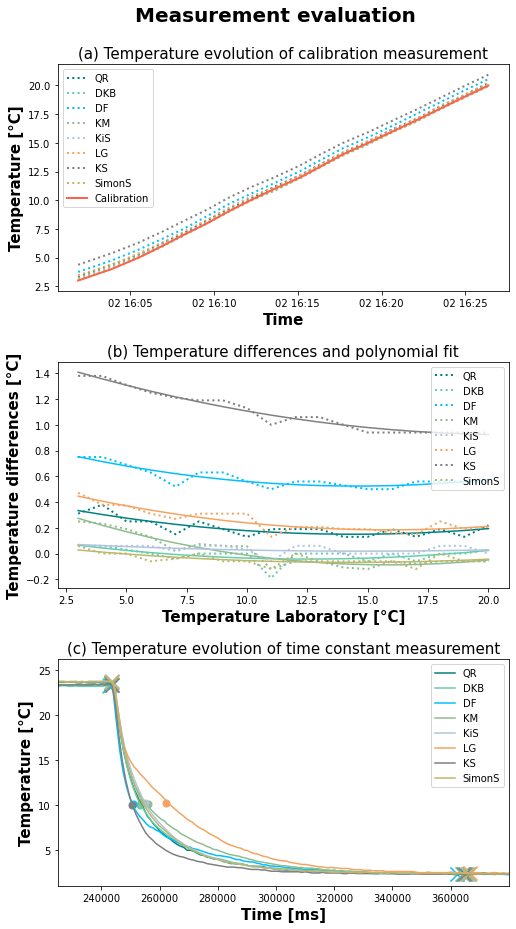

In [57]:
## Calculate 2nd order polynomial fit for three point calibration

#set variables for the names of the different temperature sensors and a color scheme for plots
sensor_list = df1_1.columns.values.tolist()[:]
c = ['tomato', 'teal', 'mediumaquamarine', 'deepskyblue', 'darkseagreen', 'lightsteelblue', 'sandybrown',
     '#7f7f7f', 'darkkhaki', '#17becf']

#start the figure command for 2 subplots
fig, (ax1,ax2, ax3) = plt.subplots(3, figsize=(7,12))
fig.tight_layout(h_pad=5)


#set variables for the calulated fit in the y-variable and the fit parameters
fit_y = np.zeros((len(sensor_list[1:]),len(df1_1[sensor_list[0]])))
fit_parameter = {}

#2nd order polnomial fit for calibration (y=ax²+bx+c)
for i, sensor in enumerate(sensor_list[1:]):
    #calculation of the fit parameters a, b, c
    fit_parameter[sensor] = np.polyfit(df1_1[sensor_list[0]].values, df1_1[sensor].values-
                                       df1_1[sensor_list[0]].values, 2)
    
    #calculation of polynomial fit using the fit parameters
    fit_y[i] = (fit_parameter[sensor][2]+fit_parameter[sensor][1]*df1_1[sensor_list[0]]+
                fit_parameter[sensor][0]*df1_1[sensor_list[0]]**2)
    
    #plot the fit and calibration measurement:
    
    #plot of temperature evolution over time of the calibration measurement time series
    ax1.plot(df1_1.index,df1_1[sensor],label=sensor, c= c[i+1], linestyle = "dotted", linewidth=2)
    ax1.set_xlabel('Time',size = 15,weight='semibold')
    ax1.set_ylabel('Temperature [°C]',size=15,weight='semibold')
    ax1.set_title('(a) Temperature evolution of calibration measurement', fontsize = 15)

    #plot of temperature differences between temperture sensors and polynomial fit
    ax2.plot(df1_1[sensor_list[0]],fit_y[i], c= c[i+1])
    ax2.plot(df1_1[sensor_list[0]].values,df1_1[sensor].values-df1_1[sensor_list[0]].values,label = sensor,
             alpha = 1,linestyle = "dotted", linewidth = 2, c=c[i+1])
    ax2.set_xlabel('Temperature Laboratory [°C]',size = 15,weight='semibold')
    ax2.set_ylabel('Temperature differences [°C]',size=15,weight='semibold')
    ax2.legend(prop=dict(size=10))
    ax2.set_title('(b) Temperature differences and polynomial fit', fontsize = 15)

ax1.plot(df1_1.index,df1_1['Calibration'],label='Calibration', c= c[0], linewidth=2)
ax1.legend(prop=dict(size=10))
my_suptitle = fig.suptitle('Measurement evaluation', fontsize=20, fontweight='bold', y=1.05)

#Load filenames of the correlation corrected temperature measurements
filenames = glob.glob(path_storage_calib+'*.LOG')

#set counter variable and variable for storing the indices of the shock time
i=0
millis_start = np.zeros(8, int)
for filename in filenames:
    #load in all files file by file
    tsensor = pd.read_csv(filename, sep=',', comment='#',names=["time","millis","ID","temperature"])
    
    #calculate temporal changes:
    diff = tsensor['temperature'].values[1:] - tsensor['temperature'].values[:-1]
    
    #find index of value that is closest to 200000ms
    diff_200000 = abs(tsensor['millis']-200000)
    millis_200000 = np.where(diff_200000 == min(diff_200000))[0][0]
    
    #find "start time", where temporal temperature change is larger than 0.1°C
    millis_start[i] = np.where(abs(diff[millis_200000:350]) >= 0.1)[0][0] + millis_200000
    start_time = tsensor['millis'][millis_start[i]]
    
    #find "end time", where temporan temperature change over an interval of n = 100s is smaller than 0.1°C
    sum_diff = np.zeros(len(diff))
    n= 100
    for k in range(len(diff)-n):
        sum_diff[k+n-1] = np.nanmean(diff[k:k+n-1])
    millis_end = np.where(abs(sum_diff[millis_start[i]+n:]) <= 0.1)[0][0]
    end_time = tsensor['millis'][millis_start[i]+millis_end+n]  
    
    ##find start and end temperature by averaging over 30s:
    temp_start = np.mean(tsensor['temperature'].values[millis_start[i]-30:\
                                                       millis_start[i]+1])
    temp_end = np.mean(tsensor['temperature'].values[millis_start[i]+millis_end+n:\
                                                     millis_start[i]+millis_end+n+31])
    
    #calculate start and end temperatures and time constant
    Temp_tau = temp_end + 1/np.e *(temp_start - temp_end)
    diff_temp = abs(tsensor['temperature'].values[:330] - Temp_tau)
    time_tau = tsensor['millis'].values[np.where(diff_temp == min(diff_temp))[0][0]]
    
    
    #plot of the sensors:
    ax3.scatter(start_time, tsensor['temperature'].values[millis_start[i]],s=200, c = c[i+1], marker='x')
    ax3.scatter(end_time, tsensor['temperature'].values[millis_start[i]+millis_end+n],s=200, c=c[i+1],
                marker='x')
    ax3.plot(tsensor["millis"], tsensor["temperature"], c=c[i+1], label = filename.split("/")[-1].
             split("_")[-1].split(".")[0])
    #plt.scatter(end_time, tsensor['temperature'].values[millis_start[i]+millis_end+n],s=100, c=c[i+1],
    #            marker='x')
    ax3.scatter(time_tau, Temp_tau, c=c[i+1], s=50)
    ax3.set_xlabel('Time [ms]',size = 15,weight='semibold')
    ax3.set_ylabel('Temperature [°C]',size=15,weight='semibold')
    ax3.legend(prop=dict(size=10))
    ax3.set_title('(c) Temperature evolution of time constant measurement', fontsize = 15)
    ax3.set_xlim(225000,379999)
    
    fig.savefig('Plots/Measurement_evaluation.pdf',dpi=fig.dpi, bbox_inches='tight',
                bbox_extra_artists=[my_suptitle])
    
    i += 1